In [1]:
# ! python -m pip install cityscapesscripts
# Clonage des scripts Github officiel de Cityscapes (certains scripts ne sont pas exposés comme module)
# !git clone https://github.com/mcordts/cityscapesScripts.git

In [ ]:
# Vérification de détection du GPU
!nvidia-smi

Sun Jan 12 17:41:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P0             13W /   80W |      80MiB /   8188MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf

print("TensorFlow version :", tf.__version__)
# Vérifier le nombre de GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# Vérifier si TensorFlow est construit avec CUDA (et cuDNN)
is_cuda_available = tf.test.is_built_with_cuda()
print("TensorFlow built with CUDA:", is_cuda_available)

# Vérifier si cuDNN est activé
is_cudnn_available = tf.test.is_built_with_cuda() and len(gpus) > 0
print("cuDNN available:", is_cudnn_available)


Num GPUs Available:  1
TensorFlow built with CUDA: True
cuDNN available: True


# Exploration des dossiers

In [2]:
from pathlib import Path
import os

# Définir la variable d'environnement CITYSCAPES_DATASET avec pathlib
os.environ["CITYSCAPES_DATASET"] = str(Path("./data").resolve())

# Vérifier la variable d'environnement CITYSCAPES_DATASET
cityscapes_dataset = os.getenv("CITYSCAPES_DATASET")
if not cityscapes_dataset:
    print("⚠️ La variable d'environnement CITYSCAPES_DATASET n'est pas définie.")
else:
    cityscapes_dataset = Path(cityscapes_dataset)  # Convertir en objet Path
    print(f"✅ La variable CITYSCAPES_DATASET est définie : {cityscapes_dataset}")


✅ La variable CITYSCAPES_DATASET est définie : C:\Users\cecil\Documents\P8\data


L'ensemble des dossiers est structuré de cette façon<br>
<code>{root}/{type}{video}/{split}/{city}/{city}_{seq:0>6}_{frame:0>6}_{type}{ext} </code><br>
Source: https://github.com/mcordts/cityscapesScripts/tree/master <br>
 - `root`  the root folder of the Cityscapes dataset. Many of our scripts check if an environment variable `CITYSCAPES_DATASET` pointing to this folder exists and use this as the default choice.
 - `type`  the type/modality of data, e.g. `gtFine` for fine ground truth, or `leftImg8bit` for left 8-bit images.
 - `split` the split, i.e. train/val/test/train_extra/demoVideo. Note that not all kinds of data exist for all splits. Thus, do not be surprised to occasionally find empty folders.
 - `city`  the city in which this part of the dataset was recorded.
 - `seq`   the sequence number using 6 digits.
 - `frame` the frame number using 6 digits. Note that in some cities very few, albeit very long sequences were recorded, while in some cities many short sequences were recorded, of which only the 19th frame is annotated.
 - `ext`   the extension of the file and optionally a suffix, e.g. `_polygons.json` for ground truth files

In [3]:
def afficher_dossiers_seulement(dossier):
    dossier = Path(dossier)
    for sous_dossier in dossier.iterdir():
        if sous_dossier.is_dir():
            print(f"|-- {sous_dossier.name}")
            # Afficher les sous-dossiers du niveau suivant
            for sous_sous_dossier in sous_dossier.iterdir():
                if sous_sous_dossier.is_dir():
                    print(f"    |-- {sous_sous_dossier.name}")

# Arborescence depuis le dossier data
afficher_dossiers_seulement(cityscapes_dataset)


|-- gtCoarse
    |-- train
    |-- train_extra
    |-- val
|-- gtFine
    |-- test
    |-- train
    |-- val
|-- leftImg8bit
    |-- test
    |-- train
    |-- train_extra
    |-- val


In [4]:
# leftImg8bit: images de la caméra en 8 bits
images_path = cityscapes_dataset / "leftImg8bit"
# gtFine : dossiers contenant les annotations fines
masks_path = cityscapes_dataset / "gtFine"
# ftCoarse contient les annotations grossières
# dossiers de masques train et val
train_masks_path = masks_path / "train"
val_masks_path = masks_path / "val"
# dossiers d'images train et val
train_images_path = images_path / "train"
val_images_path = images_path / "val"

In [5]:
afficher_dossiers_seulement(images_path)

|-- test
    |-- berlin
    |-- bielefeld
    |-- bonn
    |-- leverkusen
    |-- mainz
    |-- munich
|-- train
    |-- aachen
    |-- bochum
    |-- bremen
    |-- cologne
    |-- darmstadt
    |-- dusseldorf
    |-- erfurt
    |-- hamburg
    |-- hanover
    |-- jena
    |-- krefeld
    |-- monchengladbach
    |-- strasbourg
    |-- stuttgart
    |-- tubingen
    |-- ulm
    |-- weimar
    |-- zurich
|-- train_extra
    |-- augsburg
    |-- bad-honnef
    |-- bamberg
    |-- bayreuth
    |-- dortmund
    |-- dresden
    |-- duisburg
    |-- erlangen
    |-- freiburg
    |-- heidelberg
    |-- heilbronn
    |-- karlsruhe
    |-- konigswinter
    |-- konstanz
    |-- mannheim
    |-- muhlheim-ruhr
    |-- nuremberg
    |-- oberhausen
    |-- saarbrucken
    |-- schweinfurt
    |-- troisdorf
    |-- wuppertal
    |-- wurzburg
|-- val
    |-- frankfurt
    |-- lindau
    |-- munster


In [6]:
import random
from pathlib import Path

# Recherche d'images .png en excluant les dossiers "train_extra" et "test"
image_files = [
    img for img in images_path.rglob("*.png")
    if "train_extra" not in img.parts and "test" not in img.parts
]

if not image_files:
    raise FileNotFoundError("Aucune image .png trouvée hors des dossiers 'train_extra' et 'test'.")

# Sélectionner une image au hasard
selected_image_path = random.choice(image_files)
print(f"Image sélectionnée au hasard : {selected_image_path}")

Image sélectionnée au hasard : C:\Users\cecil\Documents\P8\data\leftImg8bit\train\aachen\aachen_000007_000019_leftImg8bit.png


In [7]:
afficher_dossiers_seulement(masks_path)

|-- test
    |-- berlin
    |-- bielefeld
    |-- bonn
    |-- leverkusen
    |-- mainz
    |-- munich
|-- train
    |-- aachen
    |-- bochum
    |-- bremen
    |-- cologne
    |-- darmstadt
    |-- dusseldorf
    |-- erfurt
    |-- hamburg
    |-- hanover
    |-- jena
    |-- krefeld
    |-- monchengladbach
    |-- strasbourg
    |-- stuttgart
    |-- tubingen
    |-- ulm
    |-- weimar
    |-- zurich
|-- val
    |-- frankfurt
    |-- lindau
    |-- munster


# Visualisation d'un exemple d'image et ses annotations

In [8]:
from pathlib import Path

# Spécifiez le chemin de départ
base_path = masks_path

# Recherche des fichiers dans les deux premiers niveaux de sous-dossiers
files = list(base_path.glob("*/*/*"))  # Recherche jusqu'à deux niveaux de sous-dossiers

# Filtrer pour ne conserver que les fichiers
files = [f for f in files if f.is_file()]

# Afficher les cinq premiers fichiers trouvés
for file in files[:5]:
    print(file)


C:\Users\cecil\Documents\P8\data\gtFine\test\berlin\berlin_000000_000019_gtFine_color.png
C:\Users\cecil\Documents\P8\data\gtFine\test\berlin\berlin_000000_000019_gtFine_instanceIds.png
C:\Users\cecil\Documents\P8\data\gtFine\test\berlin\berlin_000000_000019_gtFine_labelIds.png
C:\Users\cecil\Documents\P8\data\gtFine\test\berlin\berlin_000000_000019_gtFine_labelTrainIds.png
C:\Users\cecil\Documents\P8\data\gtFine\test\berlin\berlin_000000_000019_gtFine_polygons.json


Pour chaque image d'origine identifiée par la ville, le numéro de séquence puis le frame (00019 pour toutes les images) on remplace le suffixe par gtFine (ou un autre type). On trouve 4 fichiers par image: les annotations (polygons.json), les labelIds (33 valeurs de pixels), les instanceIds (identification des instances) et l'image colorisée correspondant à labelIds.

In [9]:
# Extraire le nom de base sans "_leftImg8bit.png"
base_name = selected_image_path.name.replace("_leftImg8bit.png", "")

# Recherche des fichiers correspondants dans gtFine
image_color = next(masks_path.rglob(f"{base_name}_gtFine_color.png"), None)
image_label = next(masks_path.rglob(f"{base_name}_gtFine_labelIds.png"), None)
image_instance = next(masks_path.rglob(f"{base_name}_gtFine_instanceIds.png"), None)

# Afficher les résultats
if image_color:
    print(f"Image color correspondante : {image_color}")
else:
    print(f"Aucune image _color trouvée pour {base_name}")

if image_label:
    print(f"Image label correspondante : {image_label}")
else:
    print(f"Aucune image _labelIds trouvée pour {base_name}")

if image_instance:
    print(f"Image instance correspondante : {image_instance}")
else:
    print(f"Aucune image _instanceIds trouvée pour {base_name}")

Image color correspondante : C:\Users\cecil\Documents\P8\data\gtFine\train\aachen\aachen_000007_000019_gtFine_color.png
Image label correspondante : C:\Users\cecil\Documents\P8\data\gtFine\train\aachen\aachen_000007_000019_gtFine_labelIds.png
Image instance correspondante : C:\Users\cecil\Documents\P8\data\gtFine\train\aachen\aachen_000007_000019_gtFine_instanceIds.png


## Génération d'une image annotée avec mappage sur 8 catégories

In [10]:
### Option 1: si cityscapesScripts est installé par pip
# pour modifier le mappage il faut changer le scripts labels.py dans le package (redméarrer le kernel)
# Note: le tuple de mappage définit également les couleurs de image_color
# !pip show cityscapesScripts
# from cityscapesscripts.preparation import json2labelImg

In [11]:
### Option 2: si le dépôt git a été cloné sous le répertoire racine
import sys
from pathlib import Path

# Chemin vers le dossier 'preparation'
preparation_path = Path(r".\cityscapesScripts\cityscapesscripts\preparation").resolve()

# Ajouter le chemin au sys.path
if str(preparation_path) not in sys.path:
    sys.path.append(str(preparation_path))

# Importer le script
import json2labelImg

In [12]:
# Dans les deux cas il faut modifier le fichier labels.py (dans helpers)

from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      0 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      0 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      0 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      0 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      0 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      0 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        1 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      1 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      1 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        2 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        2 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      2 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      2 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      2 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        3 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      3 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        3 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        3 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        4 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        4 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       5 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       6 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       6 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       7 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       7 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       7 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       7 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       7 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       7 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [13]:
# Récupérer le chemin vers le fichier JSON
image_json = next(masks_path.rglob(f"{base_name}_gtFine_polygons.json"), None)

if image_json:
    print(f"Fichier JSON trouvé : {image_json}")
    
    # Définir le chemin de sortie pour l'image générée dans le même dossier que le JSON
    image_train = image_json.parent / f"{base_name}_gtFine_trainIds.png"

    try:
        # Appeler json2labelImg avec encoding="trainIds" pour utiliser les TrainIds
        json2labelImg.json2labelImg(image_json, image_train, encoding="trainIds")
        
        print(f"Image générée et sauvegardée sous : {image_train}")

    except Exception as e:
        print(f"Erreur lors de l'exécution du script : {e}")
else:
    print(f"Aucun fichier JSON trouvé pour {base_name}")

Fichier JSON trouvé : C:\Users\cecil\Documents\P8\data\gtFine\train\aachen\aachen_000007_000019_gtFine_polygons.json
Image générée et sauvegardée sous : C:\Users\cecil\Documents\P8\data\gtFine\train\aachen\aachen_000007_000019_gtFine_trainIds.png


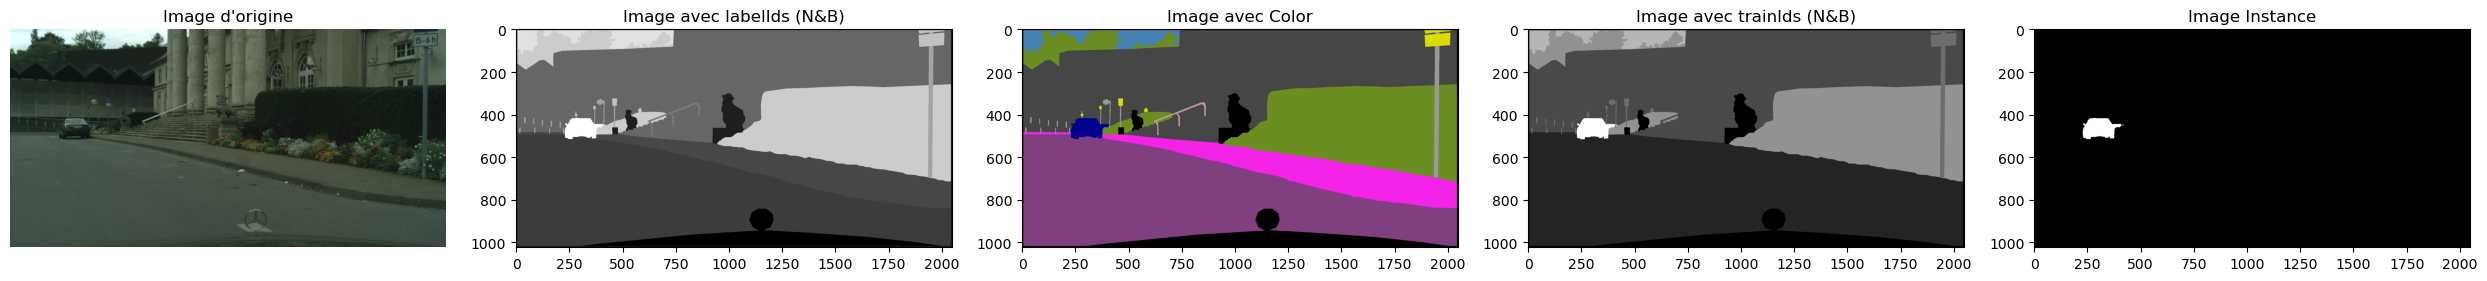

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Charger et afficher les images côte à côte
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 5 images au lieu de 4

# Affichage de l'image d'origine
img = mpimg.imread(selected_image_path)
axes[0].imshow(img)
axes[0].set_title("Image d'origine")
axes[0].axis('off')  # Désactive les axes

# Affichage de l'image label (image en niveaux de gris)
if image_label:
    img_label = mpimg.imread(image_label)
    axes[1].imshow(img_label, cmap='gray')  # Affichage en N&B
    axes[1].set_title("Image avec labelIds (N&B)")
else:
    axes[1].axis('off')

# Affichage de l'image avec les couleurs correspondant aux labels
if image_color:
    img_color = mpimg.imread(image_color)
    axes[2].imshow(img_color)
    axes[2].set_title("Image avec Color")
else:
    axes[2].axis('off')

# Affichage de l'image avec les trainIds
if image_train:
    img_train = mpimg.imread(image_train)
    axes[3].imshow(img_train, cmap='gray')  # Affichage en N&B
    axes[3].set_title("Image avec trainIds (N&B)")
else:
    axes[3].axis('off')

# Affichage de la cinquième image
if image_instance:
    img_instance = mpimg.imread(image_instance)
    axes[4].imshow(img_instance, cmap="gray")
    axes[4].set_title("Image Instance")
else:
    axes[4].axis('off')

# Afficher les images
plt.tight_layout()
plt.show()


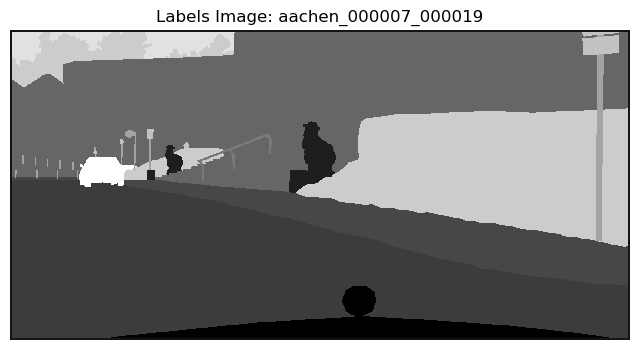

Valeurs uniques des pixels dans l'image (labels: toutes les classes) : [ 1  3  4  7  8 11 13 17 20 21 23 26]


In [15]:
from PIL import Image
import numpy as np
# Charger l'image
label_img = np.array(Image.open(image_label))
# Afficher l'image brute
plt.figure(figsize=(8, 8))
plt.imshow(label_img, cmap='gray', interpolation='nearest')
plt.title(f"Labels Image: {base_name}")
plt.axis('off')
plt.show()
# Afficher les valeurs uniques des pixels
unique_values = np.unique(label_img)
print(f"Valeurs uniques des pixels dans l'image (labels: toutes les classes) : {unique_values}")

C'est l'image avec tous les catégories fournie avec le dataset d'origine

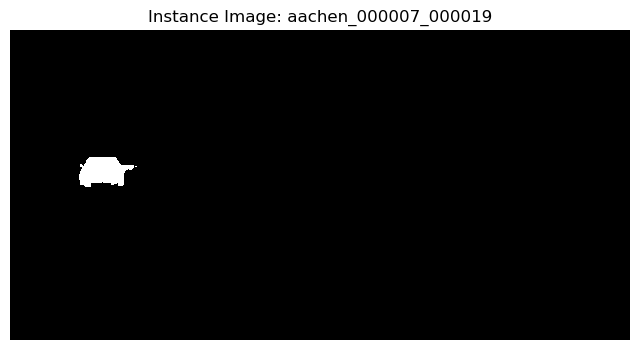

Valeurs uniques des pixels dans l'image (instances) : [    1     3     4     7     8    11    13    17    20    21    23 26000
 26001]


In [16]:
from PIL import Image
import numpy as np
# Charger l'image
instance_img = np.array(Image.open(image_instance))
# Afficher l'image brute
plt.figure(figsize=(8, 8))
plt.imshow(instance_img, cmap='gray', interpolation='nearest')
plt.title(f"Instance Image: {base_name}")
plt.axis('off')
plt.show()
# Afficher les valeurs uniques des pixels
unique_values = np.unique(instance_img)
print(f"Valeurs uniques des pixels dans l'image (instances) : {unique_values}")

C'est l'image fournie avec le dataset d'origine qui sépare les instances pour les catégories qui en possèdent.<br>
On va maintenant examiner l'image créée avec le script mappant 8 catégories

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from collections import Counter

# Charger l'image
trainId_img = np.array(Image.open(image_train))

# Obtenir les valeurs uniques dans l'image
unique_values = np.unique(trainId_img)

In [18]:
unique_values

array([0, 1, 2, 3, 4, 5, 7], dtype=uint8)

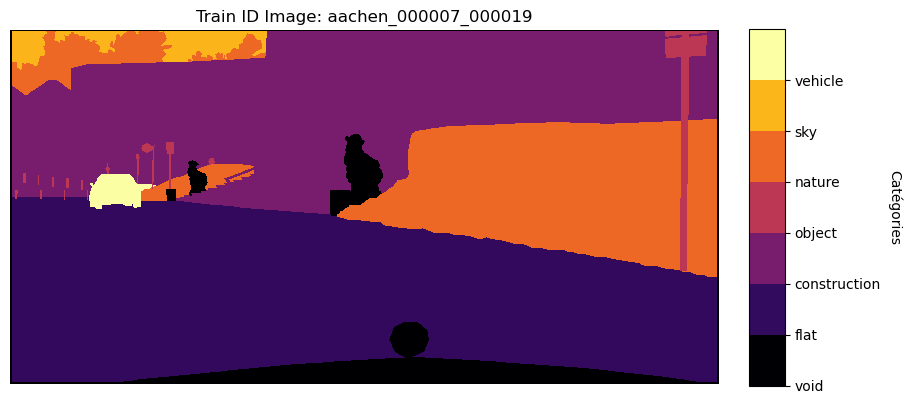

Valeurs uniques des pixels dans l'image : [0 1 2 3 4 5 7]


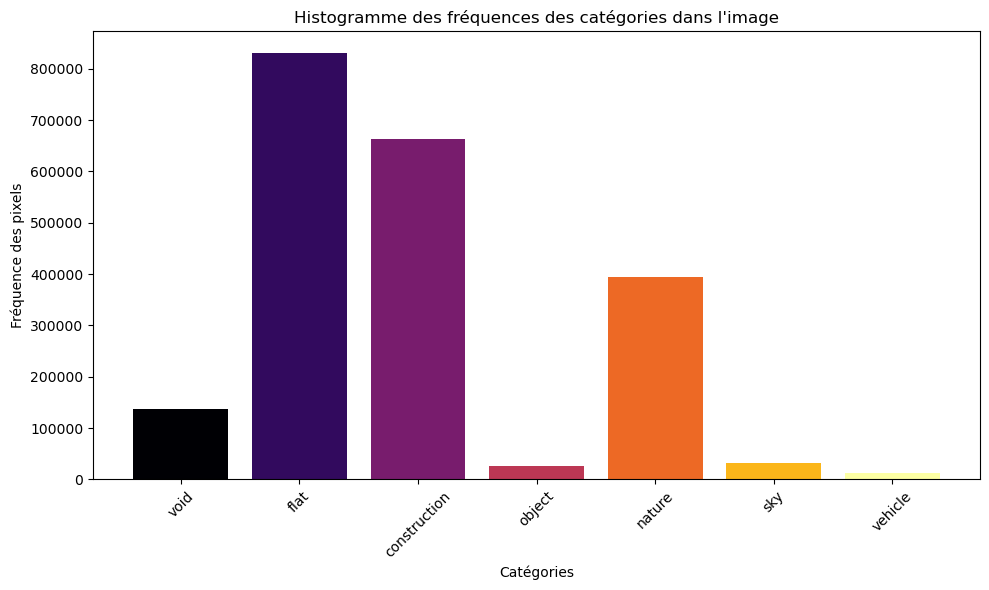

In [19]:
# Définir les catégories et mappage des trainIds
category_dict = {label.trainId: label.category for label in labels}
categories = [category_dict[trainId] for trainId in unique_values]

# Générer une palette de couleurs depuis 'inferno' pour les catégories
colormap = cm.inferno
colors = colormap(np.linspace(0, 1, len(unique_values)))

# Créer un colormap personnalisé pour affichage
custom_cmap = ListedColormap(colors)

# Créer la figure et les axes pour l'image et la barre des couleurs
fig, ax = plt.subplots(figsize=(10, 8))

# Affichage de l'image
im = ax.imshow(trainId_img, cmap=custom_cmap, interpolation='nearest')
ax.set_title(f"Train ID Image: {base_name}")
ax.axis('off')

# Ajouter une barre des couleurs manuellement
cbar = fig.colorbar(
    im, ax=ax, fraction=0.046, pad=0.04, aspect=10
)

# Définir les ticks sur la barre des couleurs
cbar.set_ticks(range(len(unique_values)))

# Associer chaque tick à une catégorie
cbar.set_ticklabels(categories)

# Ajouter un label pour la barre des couleurs
cbar.ax.set_ylabel('Catégories', rotation=-90, labelpad=15)

plt.show()

print(f"Valeurs uniques des pixels dans l'image : {unique_values}")

# Compter le nombre de pixels pour chaque trainId
pixel_counts = Counter(trainId_img.flatten())
frequencies = [pixel_counts[trainId] for trainId in unique_values]

# Afficher un histogramme aligné sur les couleurs de l'image
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, frequencies, color=colors)

# Ajouter des informations supplémentaires
plt.xlabel('Catégories')
plt.ylabel('Fréquence des pixels')
plt.title('Histogramme des fréquences des catégories dans l\'image')
plt.xticks(rotation=45)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

Le script a bien créé nos 8 classes.
Sur l'ensemble du jeu d'entrainement il est certain que les classes seront déséquilibrées, il nous faudra calculer les poids et trouver un moyen de prendre en compte ce déséquilibre.

## Création des images annotées pour l'entrainement

In [20]:
# On utilise le script createTrainIdLabelImgs inclus dans le github officiel de Cityscapes

# Converts the polygonal annotations of the Cityscapes dataset
# to images, where pixel values encode ground truth classes.
#
# The Cityscapes downloads already include such images
#   a) *color.png             : the class is encoded by its color
#   b) *labelIds.png          : the class is encoded by its ID
#   c) *instanceIds.png       : the class and the instance are encoded by an instance ID
# 
# With this tool, you can generate option
#   d) *labelTrainIds.png     : the class is encoded by its training ID
# Pour aller plus vite modifier cette ligne pour se limiter aux annotations fines
# files = filesFine # use this line if fine is enough for now.
import createTrainIdLabelImgs

In [23]:
if __name__ == "__main__":
    createTrainIdLabelImgs.main()

Processing 5000 annotation files
Progress: 100.0 %            

# Répartition des classes

Distribution des classes :
void: 642090489 pixels
flat: 2422366519 pixels
construction: 1366232774 pixels
object: 110305157 pixels
nature: 942697526 pixels
sky: 221459205 pixels
human: 74647288 pixels
vehicle: 459228242 pixels


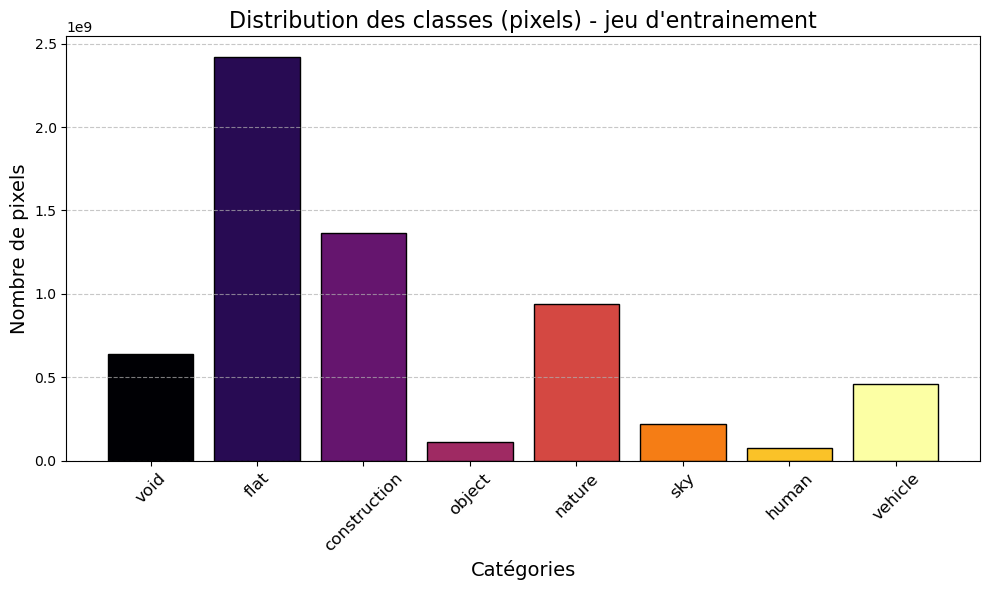

In [25]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from matplotlib import cm

# Définir le chemin des images
search_pattern = os.path.join(train_masks_path, "**", "*_labelTrainIds.png")

# Chercher toutes les images correspondantes
image_files = glob.glob(search_pattern, recursive=True)

# Vérifier que des fichiers ont été trouvés
if not image_files:
    print(f"Aucun fichier correspondant à {search_pattern} trouvé.")
    exit()

# Initialiser un tableau pour compter les classes avec np.int64
num_classes = 8  # Classes entre 0 et 7
class_counts = np.zeros(num_classes, dtype=np.int64)

# Définir le mappage des classes à leurs catégories
category_dict = {label.trainId: label.category for label in labels}  # Assurez-vous que `labels` est défini
categories = [category_dict[i] for i in range(num_classes)]

# Parcourir les images et compter les pixels par classe
for image_file in image_files:
    # Charger l'image comme un tableau numpy
    with Image.open(image_file) as img:
        image_data = np.array(img)
    
    # Compter les occurrences de chaque classe dans l'image
    pixel_counts = Counter(image_data.flatten())
    for class_id, count in pixel_counts.items():
        if class_id < num_classes:
            class_counts[class_id] += count

# Afficher les résultats
print("Distribution des classes :")
for i, count in enumerate(class_counts):
    print(f"{categories[i]}: {count} pixels")

# Générer une palette de couleurs depuis 'inferno' pour les catégories
colormap = cm.inferno
colors = colormap(np.linspace(0, 1, len(categories)))

# Tracer l'histogramme avec les couleurs et les catégories
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, class_counts, color=colors, edgecolor='black')
plt.title("Distribution des classes (pixels) - jeu d'entrainement", fontsize=16)
plt.xlabel("Catégories", fontsize=14)
plt.ylabel("Nombre de pixels", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()


In [26]:
# Calculer les poids des classes inversés en fonction de leur fréquence
total_pixels = np.sum(class_counts)  # Total de tous les pixels
class_frequencies = class_counts / total_pixels  # Fréquence relative de chaque classe
train_class_weights = 1 / class_frequencies  # Poids inverses des fréquences

# Normaliser les poids pour éviter des valeurs trop élevées
train_class_weights /= np.sum(train_class_weights)  # Normalisation

# Afficher les poids des classes
print("\nPoids des classes :")
for i, weight in enumerate(train_class_weights):
    print(f"Classe {i}: {weight:.4f}")


Poids des classes :
Classe 0: 0.0473
Classe 1: 0.0125
Classe 2: 0.0222
Classe 3: 0.2754
Classe 4: 0.0322
Classe 5: 0.1372
Classe 6: 0.4070
Classe 7: 0.0662


In [27]:
# Mappage catégories/trainId
from collections import defaultdict

# Initialiser un dictionnaire pour regrouper les trainId par catégorie
category_to_trainId = defaultdict(set)

# Remplir le dictionnaire en parcourant la liste des labels
for label in labels:
    if label.trainId >= 0:  # Ignorer les labels avec trainId négatif
        category_to_trainId[label.category].add(label.trainId)

# Convertir les sets en listes triées pour une meilleure lisibilité
category_to_trainId = {category: sorted(list(train_ids)) for category, train_ids in category_to_trainId.items()}

# Afficher le dictionnaire résultant
print("Dictionnaire des catégories et trainId associés :")
for category, train_ids in category_to_trainId.items():
    print(f"{category}: {train_ids}")


Dictionnaire des catégories et trainId associés :
void: [0]
flat: [1]
construction: [2]
object: [3]
nature: [4]
sky: [5]
human: [6]
vehicle: [7]


In [29]:
# Définir CLASSES comme la liste des clés du dictionnaire category_to_trainId
CLASSES = list(category_to_trainId.keys())

# Afficher les classes
print("CLASSES :", CLASSES)


CLASSES : ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']


Distribution des classes :
void: 126467209 pixels
flat: 399568966 pixels
construction: 215493817 pixels
object: 21568099 pixels
nature: 166308526 pixels
sky: 30708059 pixels
human: 13860769 pixels
vehicle: 74600555 pixels


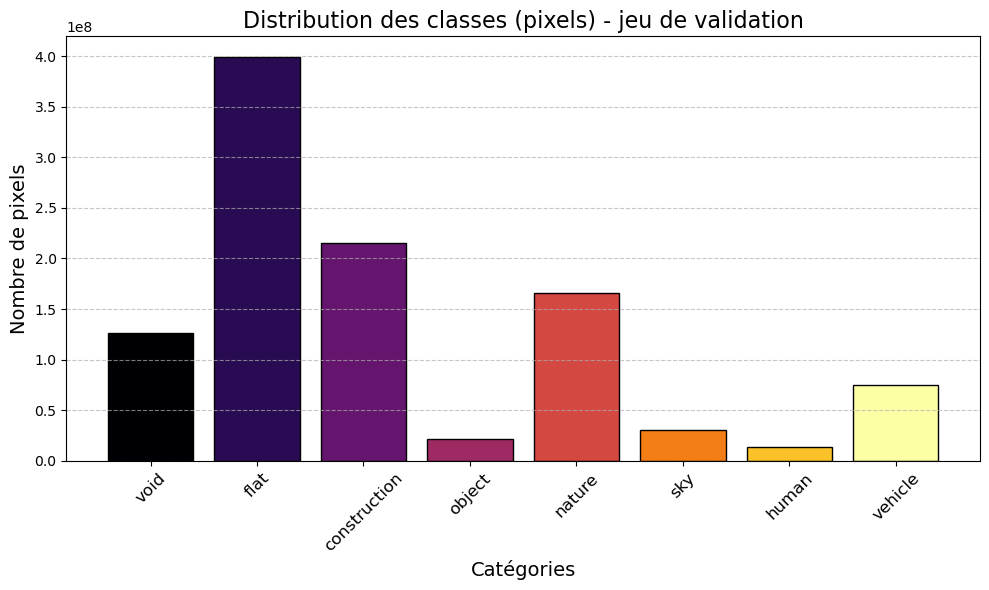

In [30]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Définir le chemin des images
search_pattern = os.path.join(val_masks_path, "**", "*_labelTrainIds.png")

# Chercher toutes les images correspondantes
image_files = glob.glob(search_pattern, recursive=True)

# Vérifier que des fichiers ont été trouvés
if not image_files:
    print(f"Aucun fichier correspondant à {search_pattern} trouvé.")
    exit()

# Initialiser un tableau pour compter les classes
num_classes = 8  # Classes entre 0 et 7
class_counts = np.zeros(num_classes, dtype=int)

# Définir le mappage des classes à leurs catégories
category_dict = {label.trainId: label.category for label in labels}  # Assurez-vous que `labels` est défini
categories = [category_dict[i] for i in range(num_classes)]

# Parcourir les images et compter les pixels par classe
for image_file in image_files:
    # Charger l'image comme un tableau numpy
    with Image.open(image_file) as img:
        image_data = np.array(img)
    
    # Compter les occurrences de chaque classe dans l'image
    pixel_counts = Counter(image_data.flatten())
    for class_id, count in pixel_counts.items():
        if class_id < num_classes:
            class_counts[class_id] += count

# Afficher les résultats
print("Distribution des classes :")
for i, count in enumerate(class_counts):
    print(f"{categories[i]}: {count} pixels")

# Générer une palette de couleurs depuis 'inferno' pour les catégories
colormap = cm.inferno
colors = colormap(np.linspace(0, 1, len(categories)))

# Tracer l'histogramme avec les couleurs et les catégories
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, class_counts, color=colors, edgecolor='black')
plt.title("Distribution des classes (pixels) - jeu de validation", fontsize=16)
plt.xlabel("Catégories", fontsize=14)
plt.ylabel("Nombre de pixels", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()


# Jeux de données train val test

Le jeu de test fourni par https://www.cityscapes-dataset.com/dataset-overview/ ne contient pas d'annotations.<br>
Plusieurs possibilités:<br>
- utiliser le jeu de validation
- constituer un jeu de test avec des images annotées grossièrement (images dans train_extra et masques dans gtCoarse)
- faire de la pseudo-annotation (ex. roboflow)
- utiliser un jeu d'images différent (Mapillarity vistas, ADE20K, CamVid, Kitti) dont il faudra adapter les annotations. C'est cette dernière solution qui est choisie. J'ai pris CamVid un jeu de données simple, qui a un nombre d'images limité (700), des catégories proches mais adaptables facilement, spécialisé dans le domaine urbain mais différent des images Cityscapes (ex: conduite à gauche). Les images sont plus petites et d'une taille inférieure mais ce ne sera pas un problème car je construirai le DataGenerator pour qu'il gère la taille.

## Jeux d'entrainement (images et masques)

In [31]:
from pathlib import Path

# Définir train_input_img_paths
train_input_img_paths = sorted([str(p) for p in Path(train_images_path).rglob("*.png")])  # Remplacez *.png par l'extension appropriée si nécessaire

# Afficher le nombre d'images
print(f"Nombre d'images dans train_images_path : {len(train_input_img_paths)}")

# Exemple d'affichage des premières images
print("Exemples de chemins d'images :", train_input_img_paths[:5])


Nombre d'images dans train_images_path : 2975
Exemples de chemins d'images : ['C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\train\\aachen\\aachen_000000_000019_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\train\\aachen\\aachen_000001_000019_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\train\\aachen\\aachen_000002_000019_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\train\\aachen\\aachen_000003_000019_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\train\\aachen\\aachen_000004_000019_leftImg8bit.png']


In [32]:
from pathlib import Path
from PIL import Image

# Initialisation des variables
image_formats = set()
image_sizes = set()

# Parcourir toutes les images dans train_images_path
for img_path in Path(train_images_path).rglob("*.png"):  # Remplacez *.png si nécessaire
    with Image.open(img_path) as img:
        # Ajouter le format et la taille aux ensembles
        image_formats.add(img.mode)
        image_sizes.add(img.size)

# Vérifier les résultats
if len(image_formats) > 1:
    print(f"Attention : Plusieurs formats détectés : {image_formats}")
else:
    print(f"Format unique : {next(iter(image_formats))}")

if len(image_sizes) > 1:
    print(f"Attention : Plusieurs tailles détectées : {image_sizes}")
else:
    print(f"Taille unique : {next(iter(image_sizes))}")


Format unique : RGB
Taille unique : (2048, 1024)


In [33]:
# Définir train_label_ids_img_paths
train_label_ids_img_paths = sorted([str(p) for p in Path(train_masks_path).rglob("*_gtFine_labelTrainIds.png")])  

# Afficher le nombre d'images
print(f"Nombre de masques dans train_masks_path : {len(train_label_ids_img_paths)}")

# Exemple d'affichage des premières images
print("Exemples de chemins d'images :", train_label_ids_img_paths[:5])


Nombre de masques dans train_masks_path : 2975
Exemples de chemins d'images : ['C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\train\\aachen\\aachen_000000_000019_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\train\\aachen\\aachen_000001_000019_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\train\\aachen\\aachen_000002_000019_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\train\\aachen\\aachen_000003_000019_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\train\\aachen\\aachen_000004_000019_gtFine_labelTrainIds.png']


In [34]:
from PIL import Image

# Initialisation des variables
mask_formats = set()
mask_sizes = set()

# Parcourir tous les masques dans train_label_ids_img_paths
for mask_path in train_label_ids_img_paths:
    with Image.open(mask_path) as mask:
        # Ajouter le format et la taille aux ensembles
        mask_formats.add(mask.mode)
        mask_sizes.add(mask.size)

# Vérifier les résultats
if len(mask_formats) > 1:
    print(f"Attention : Plusieurs formats détectés pour les masques : {mask_formats}")
else:
    print(f"Format unique pour les masques : {next(iter(mask_formats))}")

if len(mask_sizes) > 1:
    print(f"Attention : Plusieurs tailles détectées pour les masques : {mask_sizes}")
else:
    print(f"Taille unique pour les masques : {next(iter(mask_sizes))}")


Format unique pour les masques : L
Taille unique pour les masques : (2048, 1024)


## Jeux de validation (images et masques)

In [35]:
from pathlib import Path

# Définir val_input_img_paths
val_input_img_paths = sorted([str(p) for p in Path(val_images_path).rglob("*.png")])  # Remplacez *.png par l'extension appropriée si nécessaire

# Afficher le nombre d'images
print(f"Nombre d'images dans val_images_path : {len(val_input_img_paths)}")

# Exemple d'affichage des premières images
print("Exemples de chemins d'images :", val_input_img_paths[:5])


Nombre d'images dans val_images_path : 500
Exemples de chemins d'images : ['C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_000294_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_000576_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_001016_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_001236_leftImg8bit.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_001751_leftImg8bit.png']


In [36]:
# Définir val_label_ids_img_paths
val_label_ids_img_paths = sorted([str(p) for p in Path(val_masks_path).rglob("*_gtFine_labelTrainIds.png")])  

# Afficher le nombre d'images
print(f"Nombre de masques dans val_masks_path : {len(val_label_ids_img_paths)}")

# Exemple d'affichage des premières images
print("Exemples de cheminsde masques :", val_label_ids_img_paths[:5])


Nombre de masques dans val_masks_path : 500
Exemples de cheminsde masques : ['C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\val\\frankfurt\\frankfurt_000000_000294_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\val\\frankfurt\\frankfurt_000000_000576_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\val\\frankfurt\\frankfurt_000000_001016_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\val\\frankfurt\\frankfurt_000000_001236_gtFine_labelTrainIds.png', 'C:\\Users\\cecil\\Documents\\P8\\data\\gtFine\\val\\frankfurt\\frankfurt_000000_001751_gtFine_labelTrainIds.png']


In [37]:
# Fonction pour extraire la partie commune (jusqu'au troisième "_")
def extract_common_prefix(path, suffix_to_remove=None):
    stem = Path(path).stem
    if suffix_to_remove:
        stem = stem.replace(suffix_to_remove, "")
    return "_".join(stem.split("_")[:3])

# Vérifier que les chemins sont alignés sur toute la liste
aligned = all(
    extract_common_prefix(img) == extract_common_prefix(mask, "_gtFine_labelTrainIds")
    for img, mask in zip(val_input_img_paths, val_label_ids_img_paths)
)

# Afficher le résultat
if aligned:
    print("Tous les chemins des images et des masques sont bien alignés.")
else:
    print("Les chemins des images et des masques NE SONT PAS alignés.")
    # Afficher les désalignements pour investigation
    for img, mask in zip(val_input_img_paths, val_label_ids_img_paths):
        img_prefix = extract_common_prefix(img)
        mask_prefix = extract_common_prefix(mask, "_gtFine_labelTrainIds")
        if img_prefix != mask_prefix:
            print(f"Non aligné : image='{img_prefix}', masque='{mask_prefix}'")


Tous les chemins des images et des masques sont bien alignés.


On a constitué une liste d'images et de masques d'entrainement et de validation où les images et les masques sont ordonnés de façon identique.<br>
Par ailleurs on connait les dimensions et le type des images et des masques.<br>
Il est possible d'intégrer l'utilisation du script de remappage des catégories dans le dataloader, je n'ai pas choisi cette option car le jeu de test choisi CamVid n'est pas livré avec les fichiers json, nous allons mettre en oeuvre une méthode différente pour préparer les données - de plus les catégories ne sont pas identiques.

## Jeux de test

In [38]:
# clonage du dépot git
# https://github.com/lih627/CamVid.git

In [39]:
# utilisation du mappage des couleurs d'annotations (32 catégories) adapté aux catégories de cityscpaes
RGBLabel2LabelName = {
    (128, 128, 128): "sky",

    (0, 128, 64): "construction",
    (128, 0, 0): "construction",
    (64, 192, 0): "construction",
    (64, 0, 64): "construction",
    (192, 0, 128): "construction",

    (192, 192, 128): "object",
    (0, 0, 64): "object",

    (128, 64, 128): "flat",
    (128, 0, 192): "flat",
    (192, 0, 64): "flat",

    (0, 0, 192): "flat",
    (64, 192, 128): "flat",
    (128, 128, 192): "flat",

    (128, 128, 0): "nature",
    (192, 192, 0): "nature",

    (192, 128, 128): "object",
    (128, 128, 64): "object",
    (0, 64, 64): "object",

    (64, 64, 128): "construction",

    (64, 0, 128): "vehicle",
    (64, 128, 192): "vehicle",
    (192, 128, 192): "vehicle",
    (192, 64, 128): "vehicle",
    (128, 64, 64): "vehicle",

    (64, 64, 0): "human",
    (192, 128, 64): "human",
    (64, 0, 192): "human",
    (64, 128, 64): "human",

    (0, 128, 192): "human",
    (192, 0, 192): "human",

    (0, 0, 0): "void"
}

In [40]:
from pathlib import Path
import shutil

# Dossier principal CamVid
CamVid_dir = Path("./CamVid").resolve()

# Images CamVid
CamVid_images_path = CamVid_dir / "CamVid_RGB"
# Images annotées 32 catégories en couleur
CamVid_labels_path = CamVid_dir / "CamVid_Label"
# Nouveau dossier pour les images annotées en 8 classes N&B
CamVid_masks_path = CamVid_dir / "CamVidGray8"

# Vérifier si le dossier CamVidGray8 existe, et le supprimer s'il existe
if CamVid_masks_path.exists():
    shutil.rmtree(CamVid_masks_path)

# Recréer le dossier
CamVid_masks_path.mkdir()

In [41]:
# Inverser RGBLabel2LabelName pour obtenir un mapping direct de RGB -> trainId
RGBLabel2TrainId = {rgb: category_to_trainId[category] for rgb, category in RGBLabel2LabelName.items()}

# Traitement des images
for mask_file in CamVid_labels_path.glob("*.png"):
    # Charger l'image annotée
    mask = Image.open(mask_file).convert("RGB")
    mask_array = np.array(mask)

    # Créer une nouvelle image où chaque pixel est remplacé par son trainId
    new_mask_array = np.zeros(mask_array.shape[:2], dtype=np.uint8)  # Nouvelle image en niveaux de gris
    for rgb, trainId in RGBLabel2TrainId.items():
        match = (mask_array == rgb).all(axis=-1)
        new_mask_array[match] = trainId

    # Sauvegarder la nouvelle image
    new_mask = Image.fromarray(new_mask_array, mode="L")  # Mode "L" pour des valeurs de 0 à 255
    new_mask.save(CamVid_masks_path / mask_file.name)

print(f"Les images transformées ont été sauvegardées dans {CamVid_masks_path}")

Les images transformées ont été sauvegardées dans C:\Users\cecil\Documents\P8\CamVid\CamVidGray8


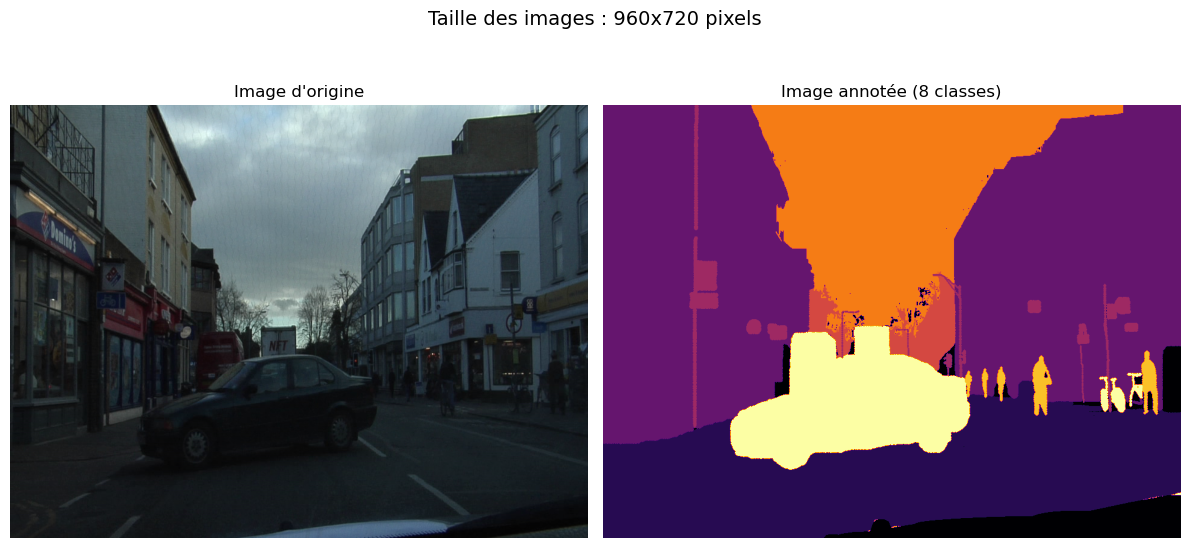

In [42]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Obtenir la liste des fichiers dans le dossier des images
image_files = list(CamVid_images_path.glob("*.png"))
if not image_files:
    raise ValueError("Aucune image trouvée dans le dossier spécifié.")

# Sélectionner une image aléatoire
random_image_file = random.choice(image_files)

# Construire le chemin de l'image annotée correspondante
label_file = CamVid_masks_path / (random_image_file.stem + "_L.png")
if not label_file.exists():
    raise ValueError(f"Le fichier annoté correspondant {label_file} est introuvable.")

# Charger les images
image = Image.open(random_image_file)
label_image = Image.open(label_file)

# Récupérer la taille des images
image_size = image.size  # Taille sous forme (largeur, hauteur)

# Afficher les deux images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Image d'origine")
axes[0].axis("off")

axes[1].imshow(label_image, cmap='inferno')
axes[1].set_title("Image annotée (8 classes)")
axes[1].axis("off")

plt.tight_layout()
plt.suptitle(f"Taille des images : {image_size[0]}x{image_size[1]} pixels", fontsize=14, y=1.02)
plt.show()

In [43]:
# Chemins des images test
test_input_img_paths = sorted([str(p) for p in Path(CamVid_images_path).rglob("*.png")])

In [44]:
test_input_img_paths[:5]

['C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVid_RGB\\0001TP_006690.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVid_RGB\\0001TP_006720.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVid_RGB\\0001TP_006750.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVid_RGB\\0001TP_006780.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVid_RGB\\0001TP_006810.png']

In [45]:
# Chemin des labels test
test_label_ids_img_paths = sorted([str(p) for p in Path(CamVid_masks_path).rglob("*.png")])

In [46]:
test_label_ids_img_paths[:5]

['C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVidGray8\\0001TP_006690_L.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVidGray8\\0001TP_006720_L.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVidGray8\\0001TP_006750_L.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVidGray8\\0001TP_006780_L.png',
 'C:\\Users\\cecil\\Documents\\P8\\CamVid\\CamVidGray8\\0001TP_006810_L.png']

# Générateur de données

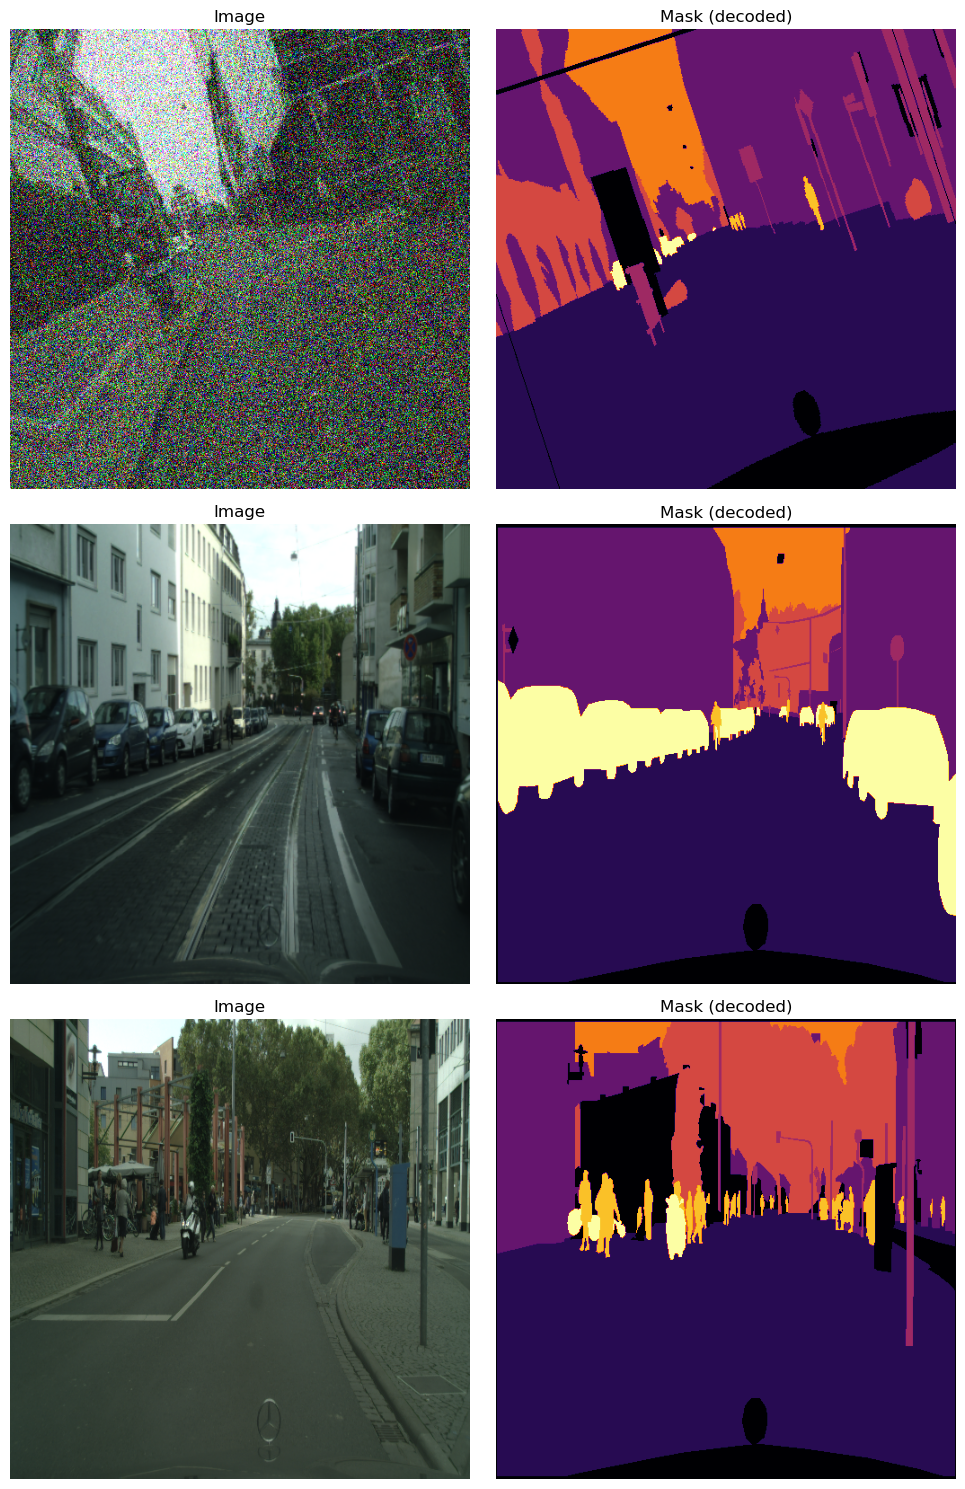

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from albumentations import Compose, HorizontalFlip, OneOf, RandomScale, Blur, GaussNoise, Resize, Rotate
import matplotlib.pyplot as plt
from typing import List, Tuple

class DataGenerator(Sequence):
    def __init__(
        self,
        image_paths: List[str],
        mask_paths: List[str],
        image_size: Tuple[int, int] = (256, 256),
        batch_size: int = 32,
        num_classes: int = 8,  # Nombre de classes
        shuffle: bool = True,
        augmentation_ratio: float = 1.0
    ):
        """
        Initialise le générateur de données.

        Args:
            image_paths (List[str]): Liste des chemins des images d'entrée.
            mask_paths (List[str]): Liste des chemins des masques.
            image_size (Tuple[int, int]): Taille des images/masks (hauteur, largeur).
            batch_size (int): Taille des lots.
            num_classes (int): Nombre total de classes pour les masques.
            shuffle (bool): Indique si les données doivent être mélangées à chaque epoch.
            augmentation_ratio (float): Ratio d'augmentation [0 à 1]. Définit la proportion des images augmentées.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.augmentation_ratio = augmentation_ratio
        self.on_epoch_end()

        # Définir les augmentations
        self.augmentation = Compose([
            HorizontalFlip(p=0.5),
            Rotate(limit=45, p=0.7),  # Rotation aléatoire entre -45° et +45°
            OneOf([
                RandomScale(scale_limit=0.2, p=0.5),
                Blur(blur_limit=5, p=0.5),
                GaussNoise(var_limit=(10.0, 50.0), p=0.5)
            ], p=0.7),
            Resize(*self.image_size)  # Garantir une taille uniforme après augmentation
        ])

    def __len__(self) -> int:
        """Retourne le nombre de lots par epoch."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Génère un lot d'images et de masques.

        Args:
            index (int): Index du lot.

        Returns:
            Tuple[np.ndarray, np.ndarray]: (batch_images, batch_masks)
        """
        start = index * self.batch_size
        end = start + self.batch_size
        batch_image_paths = self.image_paths[start:end]
        batch_mask_paths = self.mask_paths[start:end]

        batch_images, batch_masks = [], []

        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            img = self.load_image(img_path)
            mask = self.load_mask(mask_path)

            # Appliquer des augmentations selon augmentation_ratio
            if np.random.rand() < self.augmentation_ratio:
                augmented = self.augmentation(image=img, mask=mask)
                img, mask = augmented['image'], augmented['mask']

            batch_images.append(img)
            batch_masks.append(self.one_hot_encode_mask(mask))  # Encode en one-hot

        return np.stack(batch_images), np.stack(batch_masks)  # Utilisation de np.stack pour uniformiser

    def on_epoch_end(self) -> None:
        """Mélange les données après chaque epoch si shuffle est activé."""
        if self.shuffle:
            data = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(data)
            self.image_paths, self.mask_paths = zip(*data)

    def load_image(self, path: str) -> np.ndarray:
        """Charge et redimensionne une image."""
        img = load_img(path, target_size=self.image_size)
        return img_to_array(img).astype("float32") / 255.0  # Normalisation entre 0 et 1

    def load_mask(self, path: str) -> np.ndarray:
        """Charge et redimensionne un masque."""
        mask = load_img(path, target_size=self.image_size, color_mode="grayscale")
        return img_to_array(mask).astype("uint8").squeeze()

    def one_hot_encode_mask(self, mask: np.ndarray) -> np.ndarray:
        """Encode le masque en one-hot."""
        one_hot = np.zeros((*mask.shape, self.num_classes), dtype=np.uint8)
        for class_id in range(self.num_classes):
            one_hot[..., class_id] = (mask == class_id)
        return one_hot

    def visualize_batch(self, num_images: int = 5) -> None:
        """
        Visualise les premières images et masques d'un batch.

        Args:
            num_images (int): Nombre d'images/masques à afficher.
        """
        batch_images, batch_masks = self.__getitem__(0)  # Premier lot
        num_images = min(num_images, len(batch_images))
        fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

        for i in range(num_images):
            axes[i, 0].imshow(batch_images[i])
            axes[i, 0].set_title("Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(np.argmax(batch_masks[i], axis=-1), cmap="inferno")  # Décodage pour affichage
            axes[i, 1].set_title("Mask (decoded)")
            axes[i, 1].axis("off")

        plt.tight_layout()
        plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    train_gen = DataGenerator(
        image_paths=train_input_img_paths,  # Chemins des images d'entrée
        mask_paths=train_label_ids_img_paths,  # Chemins des masques correspondants
        image_size=(512, 512),  # Taille cible des images/masks
        batch_size=8,  # Taille du lot
        num_classes=8,  # Nombre de classes
        shuffle=True,  # Activation du mélange des données
        augmentation_ratio=0.5  # 50% des images seront augmentées
    )

    # Visualisation d'un batch
    train_gen.visualize_batch(num_images=3)


In [70]:
batch_images, batch_masks = train_gen[0]  # Charge le premier lot
print(f"Images batch shape: {batch_images.shape}")
print(f"Masks batch shape: {batch_masks.shape}")

Images batch shape: (8, 512, 512, 3)
Masks batch shape: (8, 512, 512, 8)


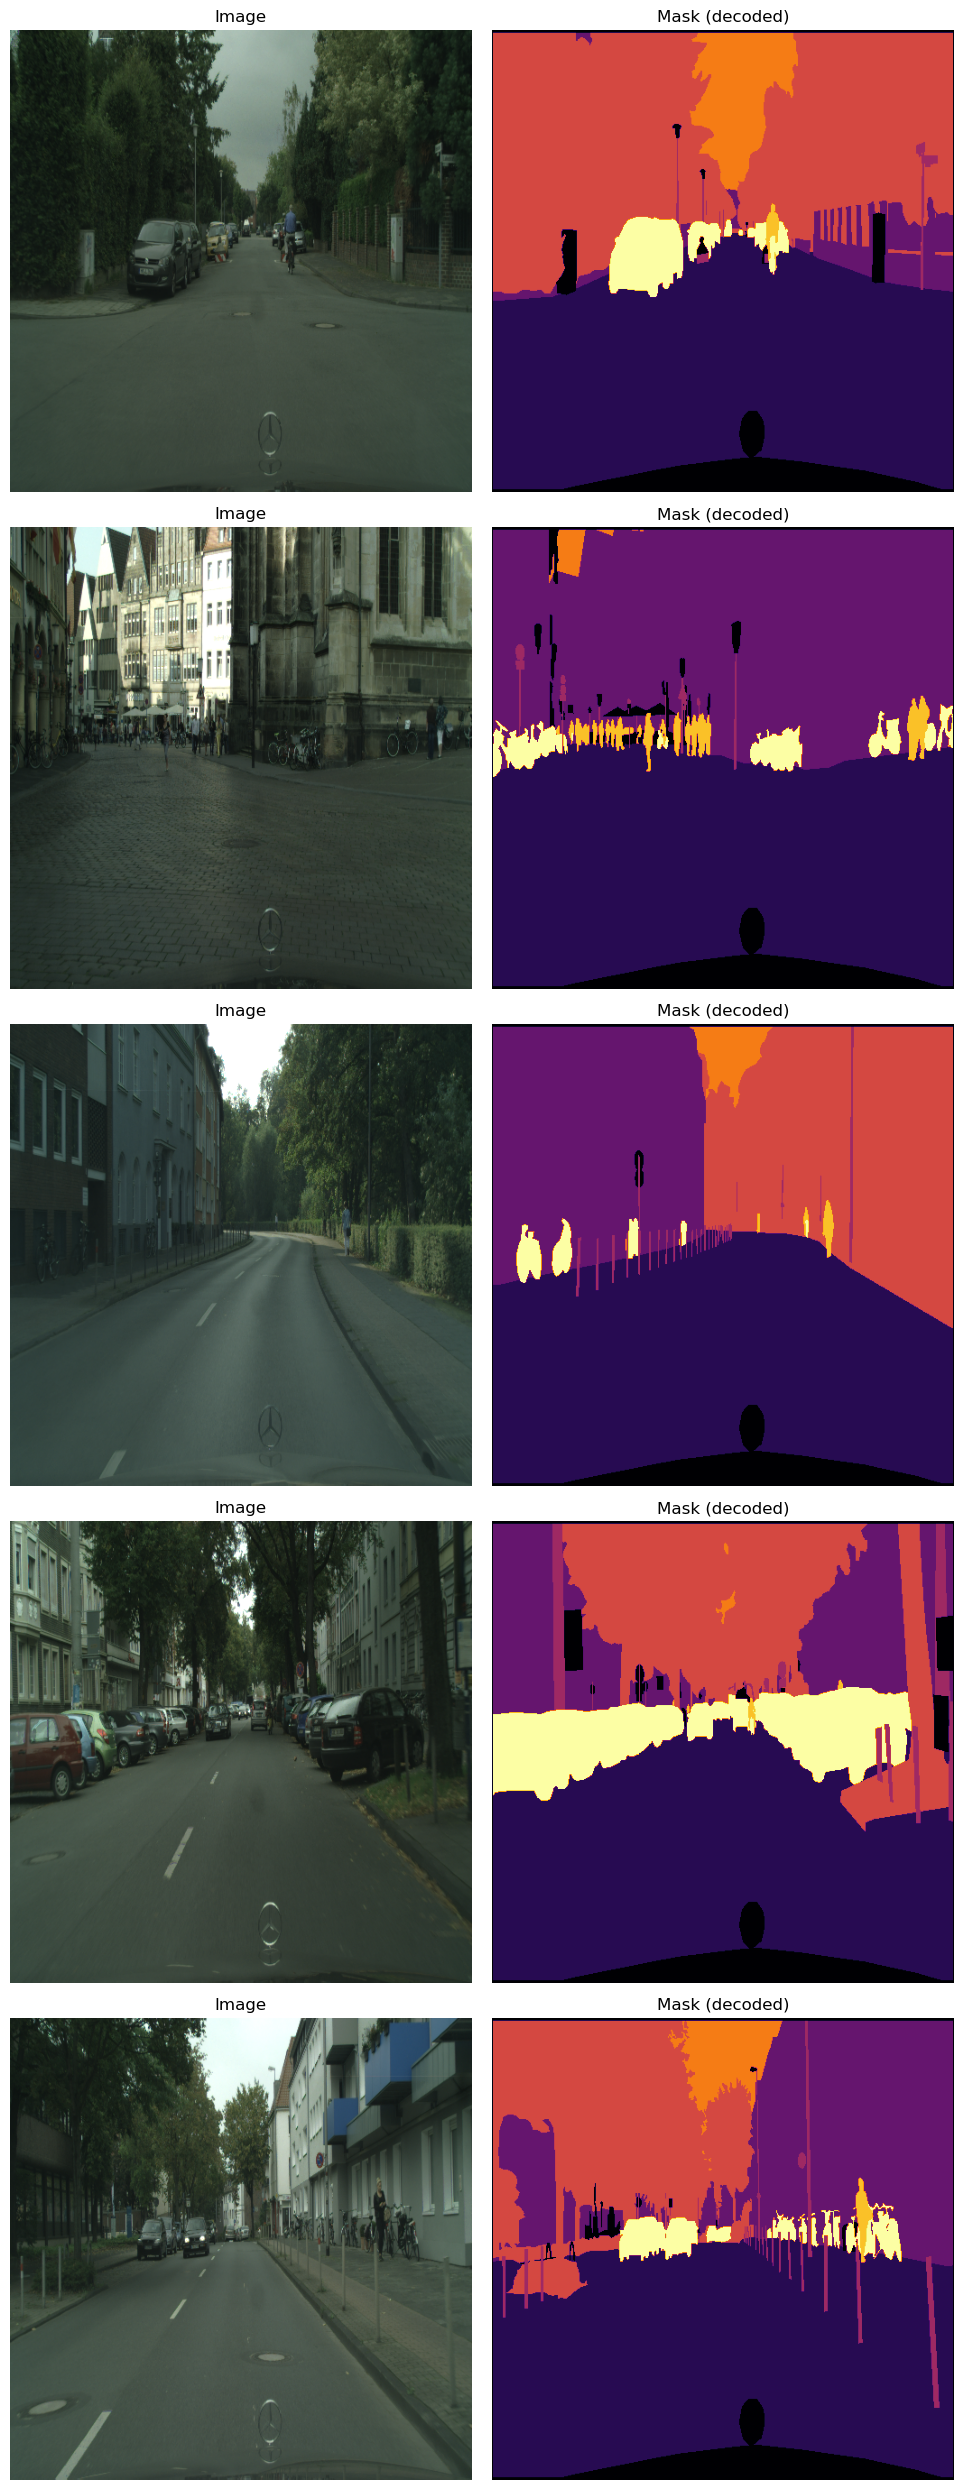

In [71]:
val_gen = DataGenerator(
    image_paths=val_input_img_paths,
    mask_paths=val_label_ids_img_paths,
    image_size=(512, 512),
    batch_size=8,
    shuffle=True,
    augmentation_ratio=0 # pas d'augmentation
)
val_gen.visualize_batch(num_images=5)

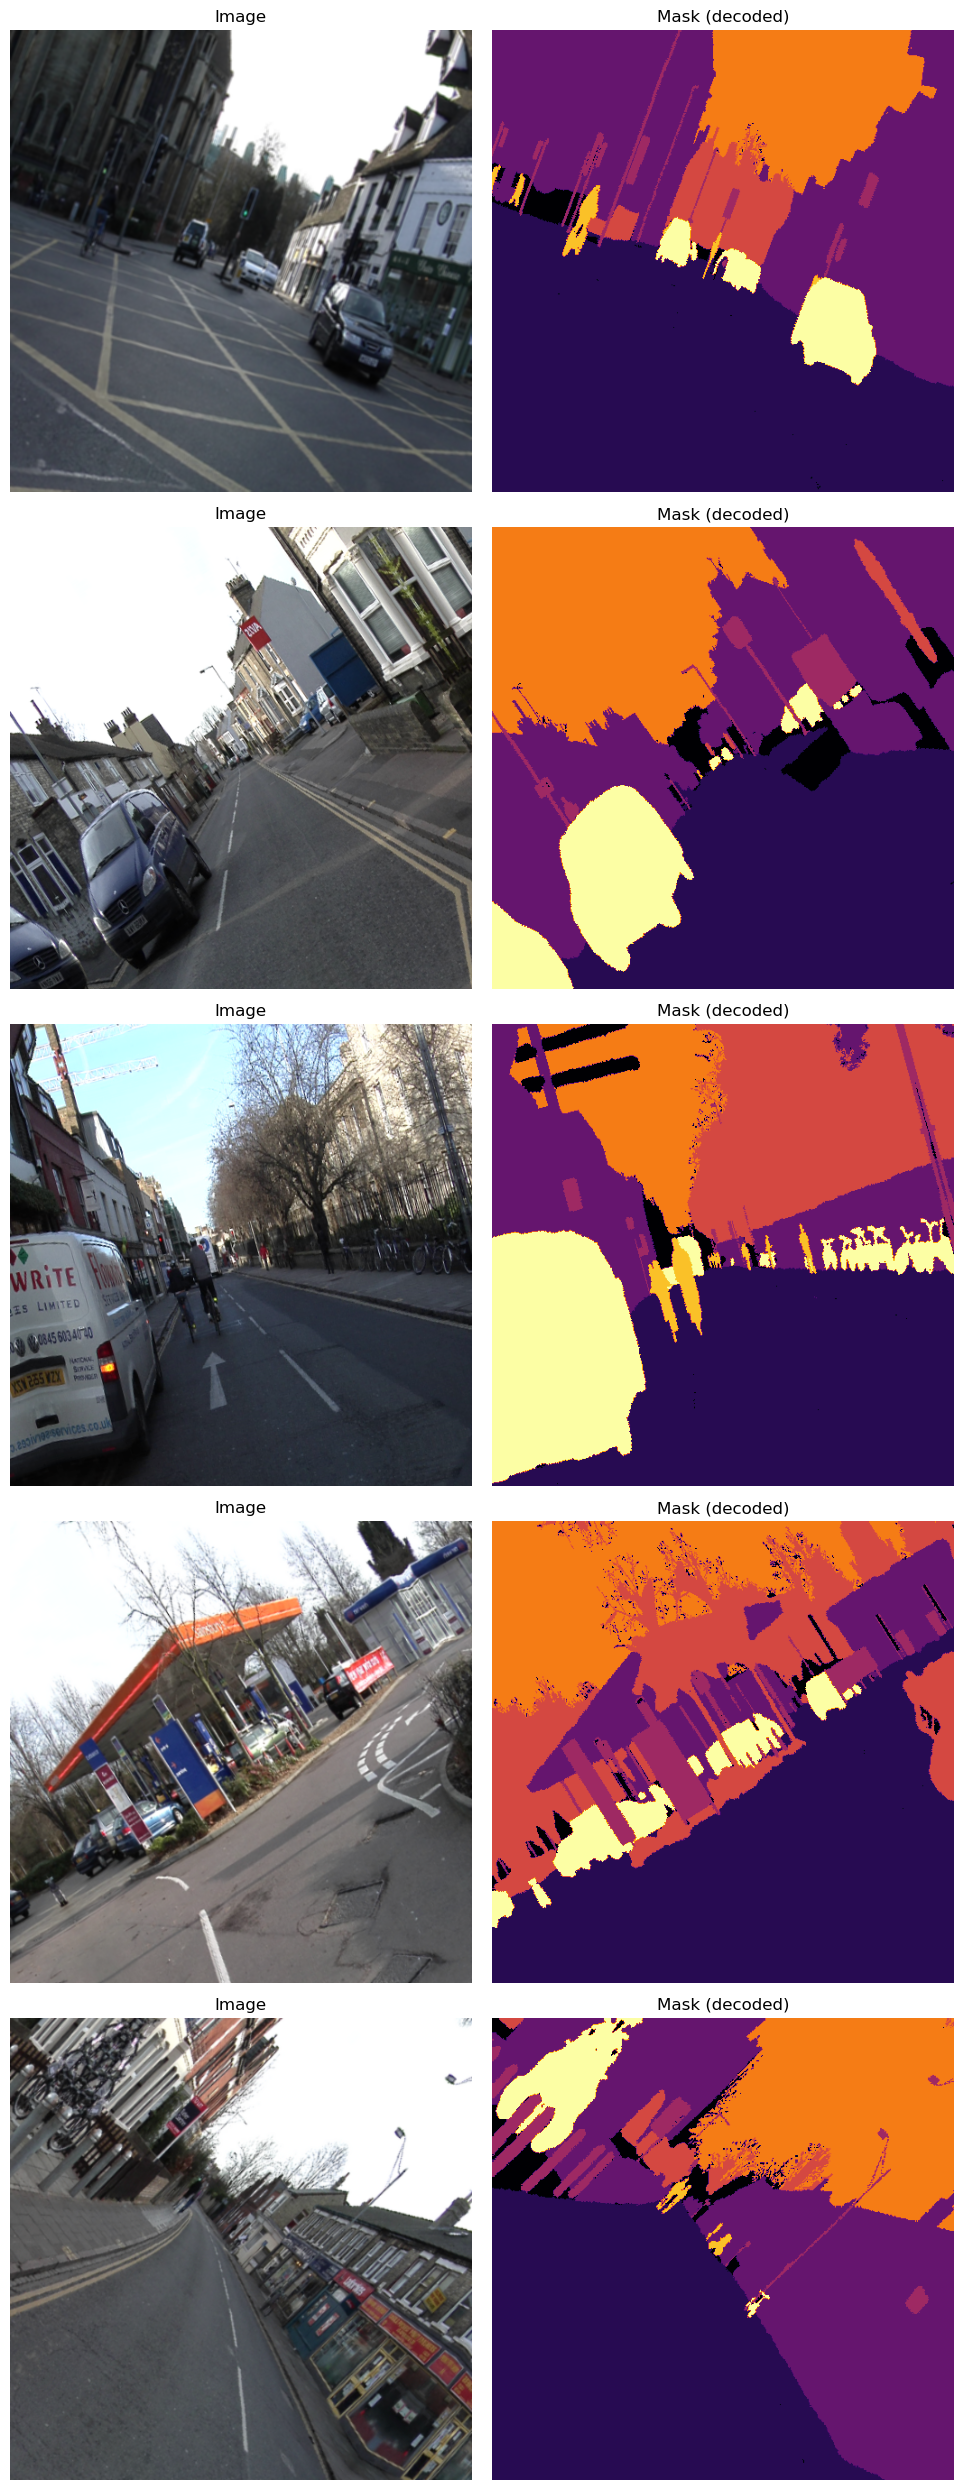

In [72]:
test_gen = DataGenerator(
    image_paths=test_input_img_paths,
    mask_paths=test_label_ids_img_paths,
    image_size=(512, 512),
    batch_size=8,
    shuffle=True,
    augmentation_ratio=1 # images augmentées avec les paramètres définis dans self.augmentation
)
test_gen.visualize_batch(num_images=5)